In [1]:
import retro
import torch
import random
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch.nn.functional as F

import pyspark

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark = (pyspark.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

mean  
max_  
difference  
frequency  
variance  
reverse tree eg autoenc  

In [2]:
actions = {
    'Left':      [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Right':     [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Jump':      [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'None':      [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Crouch':    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    # 'Dash':      [0, 0, 1, 0, 0, 0, 0, 0, 0],
    # 'RightDash': [0, 0, 1, 0, 0, 0, 0, 1, 0],
    'LeftJump':  [0, 0, 0, 0, 0, 0, 1, 0, 1],
    'RightJump': [0, 0, 0, 0, 0, 0, 0, 1, 1]
}

actions = list(actions.values())

---
### enchiridion

In [3]:

class Environment2:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')

        self.blocks_seen = []
        self.blocks_seen_urls = []
        
        self.frames_all = []
        self.actions_all = []

        self.encodings = set()
        self.encodings_frame = set()
        
        self.asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3

        self.frame = self.environment.reset()
        self.frames_all.append(self.frame)
        # self.blocks_identify(self.frame)

    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        # self.blocks_identify(self.frame)
        self.frames_all.append(self.frame)
        self.actions_all.append(action)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    # __del__ = close

    def blocks_identify_all(self):
        t = torch.tensor(np.stack(self.frames_all)).float()
        # print(t.shape)
        images = t.permute(0, 3, 1, 2)

        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        filter_ = filter_ / 16 / 16 / 3 / 255

        output = F.conv2d(input=images,
                          weight=filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        # print(output.shape)
        
        return output

    def interface_render(self):
        self.blocks_seen_urls = sorted(self.blocks_seen_urls)
        return self.frame.tolist(), list(self.encodings_frame), self.blocks_seen_urls


In [4]:

class Environment2:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')

        self.blocks_seen = []
        self.blocks_seen_urls = []
        
        self.frames_all = []
        self.actions_all = []

        self.encodings = set()
        self.encodings_frame = set()
        
        self.asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3

        self.frame = self.environment.reset()
        self.frames_all.append(self.frame)
        # self.blocks_identify(self.frame)

    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        # self.blocks_identify(self.frame)
        self.frames_all.append(self.frame)
        self.actions_all.append(action)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    __del__ = close

    def blocks_identify_all(self):
        t = torch.tensor(np.stack(self.frames_all)).float()
        # print(t.shape)
        images = t.permute(0, 3, 1, 2)

        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        filter_ = filter_ / 16 / 16 / 3 / 255

        output = F.conv2d(input=images,
                          weight=filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        # print(output.shape)
        
        return output, self.actions_all
    
    def frame_encode(self, frame):
        t = torch.tensor(frame).unsqueeze(0).float()
        # print(t.shape)
        images = t.permute(0, 3, 1, 2)

        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        filter_ = filter_ / 16 / 16 / 3 / 255

        output = F.conv2d(input=images,
                          weight=filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        # print(output.shape)
        
        return output

    def interface_render(self):
        self.blocks_seen_urls = sorted(self.blocks_seen_urls)
        return self.frame.tolist(), list(self.encodings_frame), self.blocks_seen_urls


<ipython-input-4-bf896f715ea6>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_ = torch.tensor(aa, dtype=torch.float)


2675


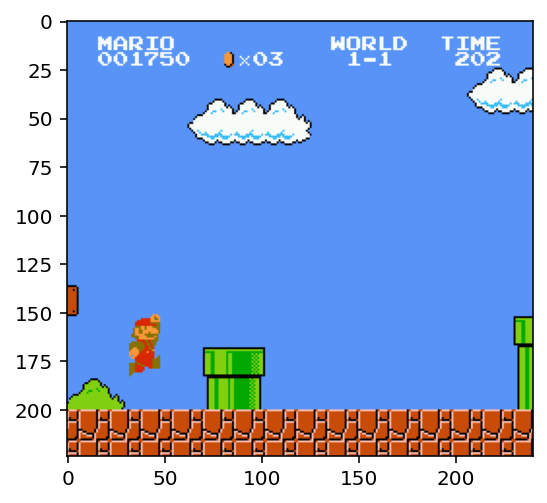

In [5]:
# %%time

import numpy as np
import random

def generate_play(step_count):
    # environment = Environment2_0()
    environment = Environment2()
    
    frame = environment.frame
    for _ in range(step_count):
        action = actions[random.randint(0, len(actions)-1)]

        frame, reward, is_done, information = environment.step(action, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all = environment.blocks_identify_all()
            
    return len(encodings.unique()), (encodings[:-1], actions_all, frame)


l2, (encodings_all1, actions_all1, f) = generate_play(800)
print(l2)
plt.imshow(f)

1043


<ipython-input-4-bf896f715ea6>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_ = torch.tensor(aa, dtype=torch.float)


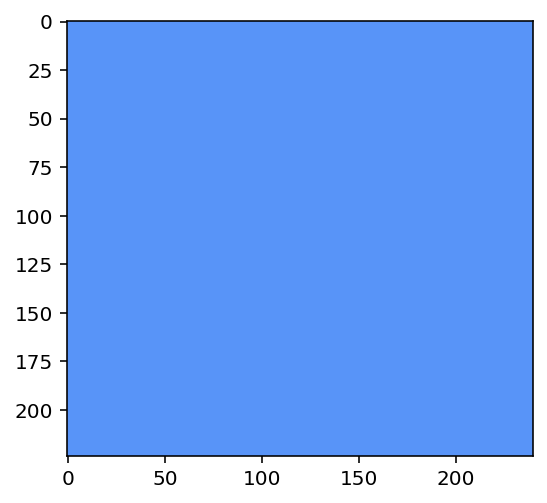

In [6]:
l2, (encodings_all2, actions_all2, f) = generate_play(800)
print(l2)
plt.imshow(f)

In [7]:
encodings_all = torch.cat([encodings_all1.reshape(-1, 9*15),
                           encodings_all2.reshape(-1, 9*15)])
actions_all = actions_all1 + actions_all2

In [8]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier()

classifier.fit(X=encodings_all,
               y=actions_all)

RandomForestClassifier()

48


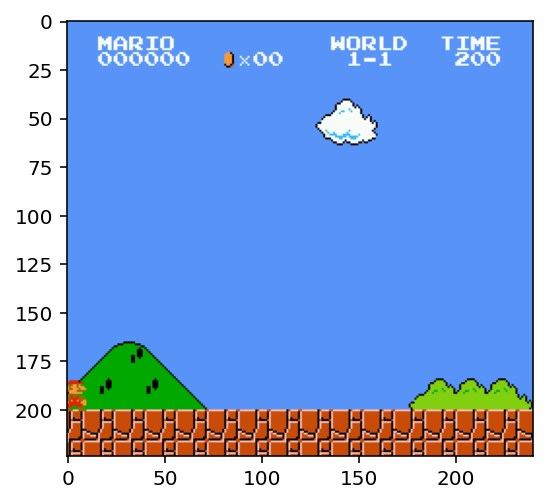

In [9]:
# %%time

import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

def generate_play(step_count, agent):
    environment = Environment2()
    
    frame = environment.frame
    for _ in range(step_count or 999999999):
        if agent:
            encoding = environment.frame_encode(frame).flatten().unsqueeze(0)
            action = agent.predict(encoding)[0]
        else:
            action = actions[random.randint(0, len(actions)-1)]
        
        frame, reward, is_done, information = environment.step(action, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all = environment.blocks_identify_all()
            
    return len(encodings.unique()), (encodings, actions_all, frame)


l2, (encodings_all, actions_all, f) = generate_play(800, classifier)
print(l2)
plt.imshow(f)

In [10]:
32x100  sparksort noblocksaccumulate innerfloat 5min21s
32x100  sparksort noblocksaccumulate broadcast  3min27s
32x100  sparksort torch full convolve 18.5s
32x1000 sparksort torch full convolve 1min47s
32x800  sparksort torch full convolve 1min39s
64x800  sparksort torch full convolve 3min41s
128x800 sparksort torch full convolve 6min18s
256x800 top32 4min32s
1024x800 top128 

128x800 c5 4xlarge local8    1min44s
128x800 c5 4xlarge local16   1min52s
1024x1000 c5 4xlarge local8 16min41s
512x1000 c5 4xlarge local8   8min14s
512x1000 c5 4xlarge local16  8min23s

SyntaxError: invalid syntax (<ipython-input-10-625dcc0af102>, line 1)

In [12]:
%%time

import matplotlib.pyplot as plt

environments = sc.parallelize(range(1024)) .map (lambda x: generate_play(800, agent=None))
# ls_frames = environments.sortByKey().collect()

ls_frames_top = environments.top(128, key=lambda x: x[0])
ls_frames = ls_frames_top[:32]


fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, (l, (encodings, actions, frame)) in zip(axs, ls_frames):
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(l)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 52120)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 595, in read_int
    r

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43601)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/spark/python/pyspark/rdd.py", line 1371, in top
    return self.mapPartitions(topIterator).reduce(merge)
  File "/opt/spark/python/pyspark/rdd.py", line 930, in reduce
    vals = self.mapPartitions(func).collect()
  File "/opt/spark/python/pyspark/rdd.py", line 889, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "/opt/spark/python/pyspark/sql/utils.py", line 131, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.8/dist-packages/py4j/protocol.py", line 326, in get_return_value
    ra

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:43601)